In [1]:
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, GRU
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers



#import seaborn as sns
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix, precision_recall_curve
#from sklearn.metrics import recall_score, classification_report, auc, roc_curve
#from sklearn.metrics import precision_recall_fscore_support, f1_score
#from sklearn.preprocessing import StandardScaler
from pylab import rcParams
tf.__version__

Using TensorFlow backend.


'1.8.0'

# Model Name

In [2]:
name = "ABS_Keras-GRU254GRU128D32D2-adam{}".format(int(time.time()))
#name_noTime = "ABS_Keras-GRU128GRU128D32D2-adam"

# Choose default months & paths, columns(features) and number of loans to load, train/test split

In [3]:
default_months = 6
nrows = 100000
train_split = 0.90
model = keras
path = 'c:/users/ugy1/abs/'
rows_for_prediction = 1000
LABELS = ('Current', 'Not Current')

column_list = ['abs_loan.originationdate', 'abs_loan.originalloanamount','abs_loan.originalloanterm',
'abs_loan.originalinterestratepercentage','abs_loan.vehiclenewusedcode','abs_loan.vehiclevalueamount',
'abs_loan.obligorcreditscore','abs_loan.obligorincomeverificationlevelcode','abs_loan.obligoremploymentverificationcode',
'abs_loan.paymenttoincomepercentage','abs_loan.remainingtermtomaturitynumber',
'abs_loan.reportingperiodbeginningloanbalanceamount','abs_loan.nextreportingperiodpaymentamountdue',
'abs_loan.reportingperiodinterestratepercentage','abs_loan.nextinterestratepercentage',
'abs_loan.servicingfeepercentage','abs_loan.otherservicerfeeretainedbyservicer',
'abs_loan.otherassesseduncollectedservicerfeeamount','abs_loan.scheduledinterestamount', 
'abs_loan.scheduledprincipalamount','abs_loan.otherprincipaladjustmentamount',
'abs_loan.reportingperiodactualendbalanceamount','abs_loan.reportingperiodscheduledpaymentamount',
'abs_loan.totalactualamountpaid','abs_loan.actualinterestcollectedamount','abs_loan.actualprincipalcollectedamount',
'abs_loan.actualothercollectedamount','abs_loan.serviceradvancedamount', 'abs_loan.currentdelinquencystatus']

# GPU Options

In [4]:
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
# sess=tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# Load data

In [5]:
df=pd.read_csv(path+'datasets/s3tab/abs_loan.csv', 
               usecols=column_list, 
               sep='\t',
               nrows=nrows,
               low_memory=False, 
              index_col='abs_loan.originationdate', 
               parse_dates=True
              )
print(df.shape)
df.dtypes

(100000, 28)


abs_loan.originalloanamount                           float64
abs_loan.originalloanterm                               int64
abs_loan.originalinterestratepercentage               float64
abs_loan.vehiclenewusedcode                             int64
abs_loan.vehiclevalueamount                           float64
abs_loan.obligorcreditscore                             int64
abs_loan.obligorincomeverificationlevelcode             int64
abs_loan.obligoremploymentverificationcode              int64
abs_loan.paymenttoincomepercentage                    float64
abs_loan.remainingtermtomaturitynumber                  int64
abs_loan.reportingperiodbeginningloanbalanceamount    float64
abs_loan.nextreportingperiodpaymentamountdue          float64
abs_loan.reportingperiodinterestratepercentage        float64
abs_loan.nextinterestratepercentage                   float64
abs_loan.servicingfeepercentage                       float64
abs_loan.otherservicerfeeretainedbyservicer           float64
abs_loan

# Clean data

In [6]:
# change columns to lower case and remove prefix to enable pandas to work
column_list=[x.lower() for x in (column_list)]
df.columns=df.columns.str.replace('abs_loan.','')
# convert objects to numeric
#df=df.convert_objects(convert_numeric=True)

# Check for null

In [7]:
df.isnull().values.any()

False

# Loan Statistics

In [8]:
df.describe()

,originalloanamount,originalloanterm,originalinterestratepercentage,vehiclenewusedcode,vehiclevalueamount,obligorcreditscore,obligorincomeverificationlevelcode,obligoremploymentverificationcode,paymenttoincomepercentage,remainingtermtomaturitynumber,...,scheduledprincipalamount,otherprincipaladjustmentamount,reportingperiodactualendbalanceamount,reportingperiodscheduledpaymentamount,totalactualamountpaid,actualinterestcollectedamount,actualprincipalcollectedamount,actualothercollectedamount,serviceradvancedamount,currentdelinquencystatus
count,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.0,100000.0,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,33770.728509,61.357590,2.437836,1.432970,4.592671e+04,779.338390,2.0,2.0,6.197697,47.169600,...,534.175101,330.888883,24999.855279,586.004785,879.572160,49.420437,834.447465,3.457836,1.300456,0.276480
std,16406.941224,10.114684,1.530379,0.495489,8.100001e+04,65.766079,0.0,0.0,5.434317,14.491508,...,280.909495,2929.811645,15105.987654,299.780911,2966.534912,49.433409,2961.837151,27.656165,12.896672,2.404898
min,3741.290000,16.000000,0.010000,1.000000,0.000000e+00,0.000000,2.0,2.0,0.000000,3.000000,...,0.000000,-72031.970000,0.000000,0.000000,-72031.970000,-164.050000,-72031.970000,0.000000,0.000000,0.000000
25%,22686.080000,60.000000,1.000000,1.000000,3.110000e+04,729.000000,2.0,2.0,2.997500,42.000000,...,358.397500,0.000000,14959.700000,396.160000,388.440000,19.000000,351.567500,0.000000,0.000000,0.000000
50%,30854.720000,60.000000,1.900000,1.000000,4.324000e+04,786.000000,2.0,2.0,4.950000,50.000000,...,481.920000,0.000000,22875.780000,530.930000,536.420000,36.340000,490.570000,0.000000,0.000000,0.000000
75%,41369.707500,72.000000,2.990000,2.000000,5.644125e+04,834.000000,2.0,2.0,7.890000,57.000000,...,641.502500,0.000000,32429.337500,701.470000,748.000000,64.520000,683.840000,0.000000,0.000000,0.000000
max,189984.120000,72.000000,15.140000,2.000000,1.021234e+07,900.000000,2.0,2.0,96.950000,72.000000,...,4923.280000,95550.670000,177603.400000,4975.230000,97288.810000,1666.400000,97135.010000,3831.100000,853.390000,118.000000


# Current Vs Non-Current

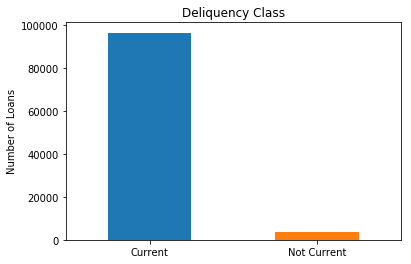

Number of loans Current : 96414     Number of loans Not Current : 3586


In [9]:
count_classes = pd.value_counts(df.currentdelinquencystatus>0, sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title('Deliquency Class')
plt.ylabel("Number of Loans")
plt.show()
print('Number of loans Current :', count_classes[0],'   ', 'Number of loans Not Current :', count_classes[1],)

In [10]:
pd.value_counts(df.currentdelinquencystatus)

0      96414
1       1001
2        336
3        304
4        253
5        205
6        176
7        140
8        113
9        108
10        86
11        83
12        72
14        71
15        66
13        62
16        60
17        56
18        37
19        30
21        28
23        28
25        24
20        23
22        21
28        21
26        18
24        17
27        16
32        10
       ...  
41         3
52         2
72         2
45         2
47         2
38         1
71         1
118        1
55         1
50         1
57         1
58         1
59         1
60         1
73         1
43         1
74         1
49         1
109        1
79         1
80         1
104        1
85         1
103        1
39         1
89         1
90         1
61         1
100        1
62         1
Name: currentdelinquencystatus, Length: 75, dtype: int64

# Label Creation

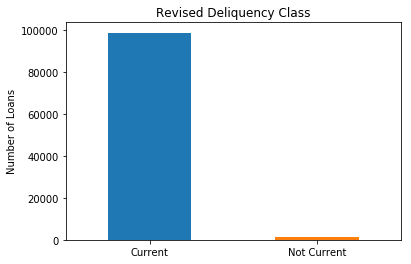

Number of loans Current : 98689     Number of loans Defaulted : 1311
New Vehicle Percent default:  1.311


In [11]:
def map_label(*args):
    columns = [col for col in args]
    for column in columns:
        if column > default_months:
            return 1
        elif column <= default_months:
            return 0
        
df['label'] = list(map(map_label, df.currentdelinquencystatus ))


count_classes = pd.value_counts(df.label, sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title('Revised Deliquency Class')
plt.ylabel("Number of Loans")
plt.show()
print('Number of loans Current :', count_classes[0],'   ', 'Number of loans Defaulted :', count_classes[1],)
print('New Vehicle Percent default: ', (count_classes[1]/(count_classes[0]+count_classes[1]))*100 )

# Loan Balance Amount at the End of Reporting Period

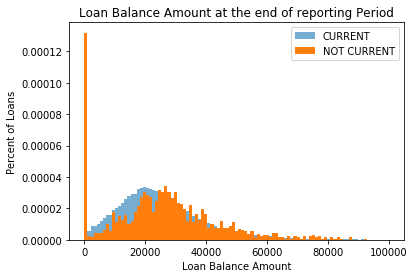

In [12]:
current_df = df[df.label==0]
not_current_df = df[df.label==1]
bins = np.linspace(0, 100000, 100)
plt.hist(current_df.reportingperiodactualendbalanceamount, bins, alpha=0.6, density=True, label='CURRENT')
plt.hist(not_current_df.reportingperiodactualendbalanceamount, bins, alpha=1, density=True, label='NOT CURRENT')
plt.legend(loc='upper right')
plt.title("Loan Balance Amount at the end of reporting Period")
plt.xlabel('Loan Balance Amount')
plt.ylabel('Percent of Loans')
plt.show()
#pd.value_counts(df.reportingperiodactualendbalanceamount[df.label==0])


# New Vehicle Default

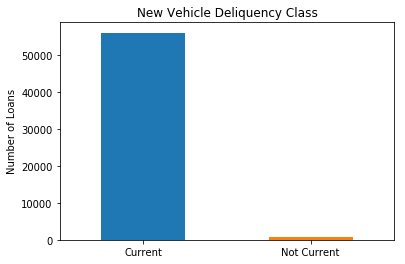

Number of loans Current : 56062     Number of loans Defaulted : 641
New Vehicle Percent default:  1.13045165159


In [13]:
count_classes = pd.value_counts(df.label[df.vehiclenewusedcode==1], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title('New Vehicle Deliquency Class')
plt.ylabel("Number of Loans")
plt.show()
print('Number of loans Current :', count_classes[0],'   ', 'Number of loans Defaulted :', count_classes[1],)
print('New Vehicle Percent default: ', (count_classes[1]/(count_classes[0]+count_classes[1]))*100 )

# Used Vehicle default

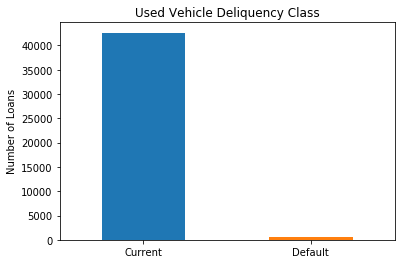

Number of loans Current : 42627     Number of loans Defaulted : 670
Used Vehicle Percent default:  1.54745132457


In [14]:
LABELS = ('Current', 'Default')
count_classes = pd.value_counts(df.label[df.vehiclenewusedcode==2], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title('Used Vehicle Deliquency Class')
plt.ylabel("Number of Loans")
plt.show()
print('Number of loans Current :', count_classes[0],'   ', 'Number of loans Defaulted :', count_classes[1],)
print('Used Vehicle Percent default: ', (count_classes[1]/(count_classes[0]+count_classes[1]))*100 )

#  Clean up for Machine Learning

In [15]:
df.fillna(0, inplace=True)
df=df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)
df.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,vehiclenewusedcode,vehiclevalueamount,obligorcreditscore,obligorincomeverificationlevelcode,obligoremploymentverificationcode,paymenttoincomepercentage,remainingtermtomaturitynumber,...,otherprincipaladjustmentamount,reportingperiodactualendbalanceamount,reportingperiodscheduledpaymentamount,totalactualamountpaid,actualinterestcollectedamount,actualprincipalcollectedamount,actualothercollectedamount,serviceradvancedamount,currentdelinquencystatus,label
abs_loan.originationdate,,,,,,,,,,,,,,,,,,,,,
2012-12-31,25124.50,72,3.29,1,44395.0,812,2,2,2.66,13,...,0.0,4479.55,385.00,385.00,13.30,371.70,0.0,0.0,0,0
2012-12-31,43257.34,72,3.29,1,50595.0,817,2,2,3.99,14,...,0.0,8328.13,663.71,663.71,24.58,639.13,0.0,0.0,0,0
2012-12-31,56917.54,72,3.29,1,62695.0,818,2,2,6.97,14,...,0.0,11979.91,873.39,873.39,35.14,838.25,0.0,0.0,0,0
2012-12-31,42003.57,72,3.29,1,46995.0,791,2,2,2.96,13,...,0.0,8182.63,643.71,643.71,24.12,619.59,0.0,0.0,0,0
2012-12-31,77217.85,72,3.29,1,76145.0,712,2,2,10.37,14,...,0.0,16336.95,1184.89,1160.89,47.92,1136.97,24.0,0.0,0,0


# Preparing data for Machine Learning

In [16]:
# prepare label
Y=df.label.values
Y.shape

(100000,)

In [17]:
# reshape labels for machine learning
Y=Y.reshape(Y.shape[0],1)
Y.shape

(100000, 1)

In [18]:
# prepare input data
input=df.values
input.shape

(100000, 29)

In [19]:
# calculate train/test split
len_train = int(len(input)*train_split)
print(len_train)

90000


In [20]:
# apply train/test split to labels
y_train = Y[0:len_train]
y_test = Y[len_train:]

In [21]:
#drop unneeded columns for creating input data
df.drop(['currentdelinquencystatus','label'], axis=1, inplace=True)

In [22]:
#reshape input data for machine learning
input=input.reshape(input.shape[0], input.shape[1], 1)
input.shape

(100000, 29, 1)

In [23]:
# apply train/test split to input data
x_train = input[0:len_train]
x_test = input[len_train:]

# Normalize input data

In [24]:
x_train_keras_scaled = keras.utils.normalize(x_train, axis=-1, order=2)
x_test_keras_scaled = keras.utils.normalize(x_test, axis=-1, order=2)
x_train_keras_scaled.shape

(90000, 29, 1)

# Model Architecture

In [25]:
model = keras.Sequential()
model.add(keras.layers.GRU(254, activation='relu', input_shape=(x_train_keras_scaled.shape[1:]), return_sequences=True))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.GRU(128, activation='relu'))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(2, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)


# Model Configuration

In [26]:
#save the best model
# keras.callbacks.Callback()
# checkPoint = ModelCheckpoint(filepath = path+'model/'+name+'.h5',
#                             save_best_only = True,
#                             verbose=0)
# tensorboard = TensorBoard(log_dir=path+'logs/{}'.format(name),
#                          histogram_freq=0,
#                          batch_size=32,
#                          write_graph=True,
#                          write_images=False)
# history = keras.callbacks.History()

# Train the Model

In [27]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(x_train, y_train, epochs=1, validation_data=(x_test_keras_scaled, y_test), 
         # callbacks = [
   # baseLogger,
    #history,
    #tensorboard,
    #learningRateScheduler,
    #reduceLROnPlateau
#], 
          shuffle=False
)


Train on 90000 samples, validate on 10000 samples
Epoch 1/1
90000/90000 [==============================] - 271s 3ms/step - loss: 0.2509 - acc: 0.9844 - val_loss: 0.4077 - val_acc: 0.9850


# Save the Model

In [28]:
model.save(path+'model/'+name+'.h5')

In [29]:
test_loss, test_acc = model.evaluate(x_test_keras_scaled, y_test)
print('Test Loss : ',test_loss,' ','Test Accuracy : ', test_acc)

10000/10000 [==============================] - 7s 727us/step
Test Loss :  0.407675276089   Test Accuracy :  0.985


# Load Saved Model

In [30]:
#saved_model = load_model(path+'model/ABS_Keras-GRU254GRU128D32D2-adam1540234865.h5')

In [31]:
#test_loss, test_acc = saved_model.evaluate(x_test_keras_scaled, y_test)
#print('Test Loss : ',test_loss,' ','Test Accuracy : ', test_acc)